In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import my_afml_fncs
# import matplotlib as mpl
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

5.2 Generate a time series that follows a sinosoidal function. This is a stationary series with memory

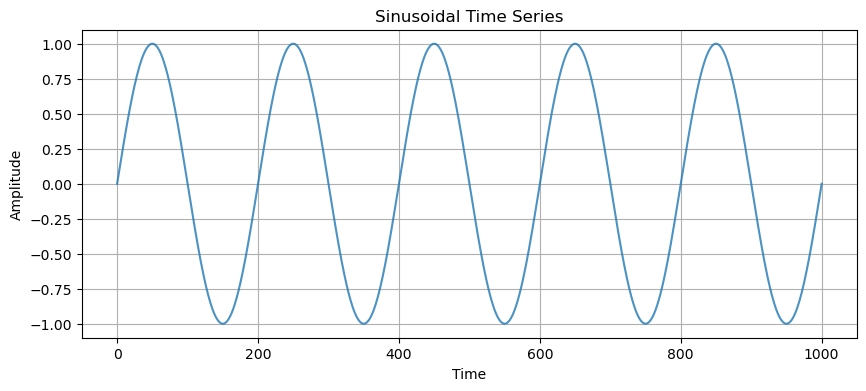

(-11705902195753.672, 0.0)

In [19]:
# Parameters
num_samples = 1000  # Number of samples
t = np.linspace(0, 1000, num_samples)  # Time vector
frequency = 5  # Frequency of the sine wave
amplitude = 1  # Amplitude of the sine wave
phase = 0  # Phase shift

# Generate sinusoidal time series
sinusoidal_series = amplitude * np.sin(2 * np.pi * frequency * t / num_samples + phase)

# Plot the sinusoidal time series
plt.figure(figsize=(10, 4))
plt.plot(t, sinusoidal_series, linestyle='-', alpha=0.8)
plt.title("Sinusoidal Time Series")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

#1 Perform the ADF test
adf_result = adfuller(sinusoidal_series)

# Extract the test statistic and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

adf_statistic, p_value


In [ ]:
# Add noise to the sinusoidal series
noise = np.random.normal(0, 0.2, num_samples)  # Gaussian noise with mean 0 and std 0.1
noisy_series = sinusoidal_series + noise

# Plot the noisy time series
plt.figure(figsize=(10, 4))
plt.plot(t, noisy_series, linestyle='-', alpha=0.8, label='Noisy Series')
plt.title("Noisy Sinusoidal Time Series")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()

#1 Perform the ADF test
adf_result = adfuller(noisy_series)

# Extract the test statistic and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

adf_statistic, p_value

5.2 b: Shift every observation by the same positive value. Compute the cumulative sum of the observations. This is a non-stationary series with memory

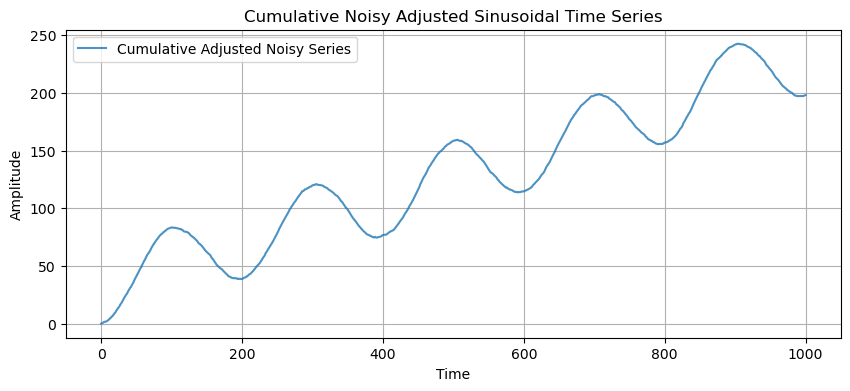

(-1.0025215219004455, 0.7523435233598388)

In [27]:
adjusted_series = noisy_series + 0.2
cumulative_adjusted_series = np.cumsum(adjusted_series)

# Plot the cumulative adjusted noisy time series
plt.figure(figsize=(10, 4))
plt.plot(t, cumulative_adjusted_series, linestyle='-', alpha=0.8, label='Cumulative Adjusted Noisy Series')
plt.title("Cumulative Noisy Adjusted Sinusoidal Time Series")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()

#1 Perform the ADF test
adf_result = adfuller(cumulative_adjusted_series)

# Extract the test statistic and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

adf_statistic, p_value


5.2.ii Apply an expanding window fracDiff, with tau=1e-2. What is the minimum d value do you get a p-value below 5%?

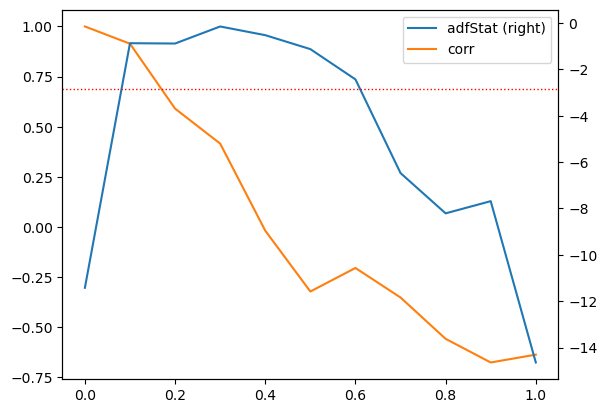

In [57]:
path, instName = './', 'Sinusoidal_Method12'
out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
# df0 = pd.read_csv(path + instName + '.csv', index_col=0, parse_dates=True)
df0=pd.DataFrame(cumulative_adjusted_series, index=t, columns=['Close'])
for d in np.linspace(0, 1, 11):
    df1 = np.log(df0[['Close']]) # downcast to daily obs
    df2 = my_afml_fncs.fracDiff(df1, d, thres=.01)
    corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0, 1]
    df2 = adfuller(df2['Close'], maxlag=1, regression='c', autolag=None)
    out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]  # with critical value
out.to_csv(path + instName + '_testMinFFD.csv')
out[['adfStat', 'corr']].plot(secondary_y='adfStat')
plt.axhline(out['95% conf'].mean(), linewidth=1, color='r', linestyle='dotted')
plt.savefig(path + instName + '_testMinFFD.png')


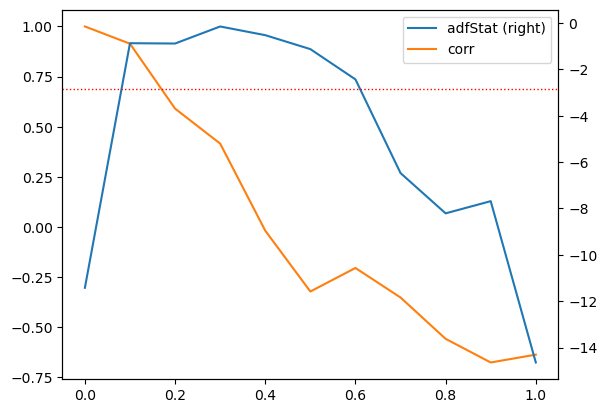

In [12]:
path,instName='./','ES1_Index_Method12'
out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
# df0=pd.read_csv(path+instName+'.csv',index_col=0,parse_dates=True)
df0=pd.DataFrame(cumulative_adjusted_series, index=t, columns=['Close'])
for d in np.linspace(0,1,11):
    df1=np.log(df0[['Close']]) # downcast to daily obs
    df2=my_afml_fncs.fracDiff_FFD(df1,d,thres=0.001)
    corr=np.corrcoef(df1.loc[df2.index,'Close'],df2['Close'])[0,1]
    df2=adfuller(df2['Close'],maxlag=1,regression='c',autolag=None)
    out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # with critical value
out.to_csv(path+instName+'_testMinFFD.csv')
out[['adfStat','corr']].plot(secondary_y='adfStat')
plt.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted')
plt.savefig(path+instName+'_testMinFFD.png')


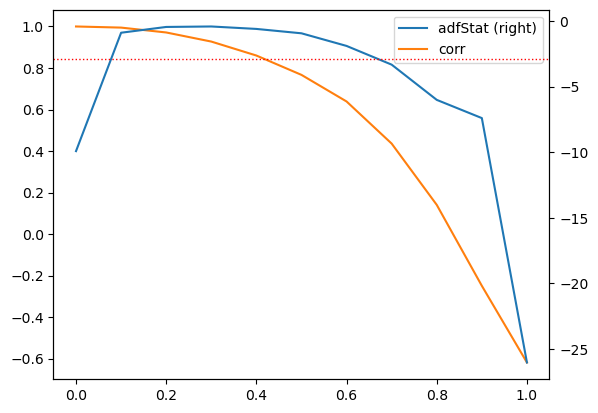

5.3 Take the series from exercise 5.2.b

(a) Fit the series to a sine function. What is the R-squared?


In [37]:
x_data=t
y_data=cumulative_adjusted_series

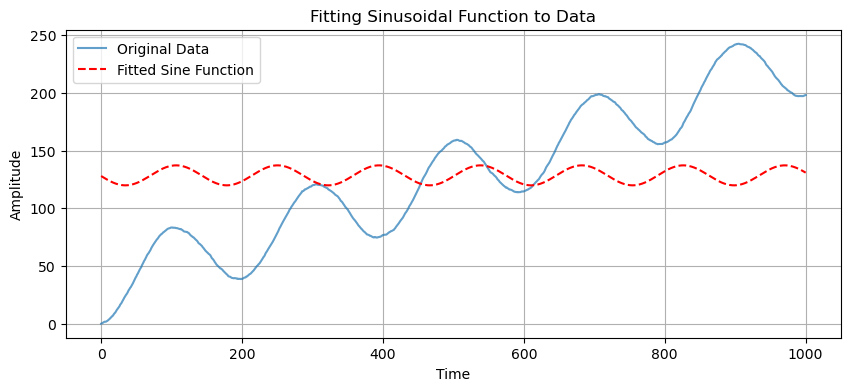

In [38]:

# Define the sine function to fit
def sine_function(x, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * x + phi) + C

# Fit the sine function to the data
popt, pcov = curve_fit(sine_function, x_data, y_data, p0=[1, 0.005, 0, 0])

# Extract the fitted parameters
A_fit, f_fit, phi_fit, C_fit = popt

# Generate fitted y-values
y_fit = sine_function(x_data, A_fit, f_fit, phi_fit, C_fit)

# Plot the original and fitted data
plt.figure(figsize=(10, 4))
plt.plot(x_data, y_data, label='Original Data', alpha=0.7)
plt.plot(x_data, y_fit, label='Fitted Sine Function', linestyle='--', color='red')
plt.title("Fitting Sinusoidal Function to Data")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Calculate the R-squared value
r_squared = r2_score(y_data, y_fit)
r_squared

0.010007518248410507

5.3.b. Apply FFD(d=1). Fit the series to a sine function. What is the r-squared?

In [63]:
df=pd.DataFrame(cumulative_adjusted_series,index=t,columns=['Close'])

In [72]:
ffd1=my_afml_fncs.fracDiff_FFD(df,d=0.1,thres=0.001)
y_data=ffd1['Close']
x_data=ffd1.index

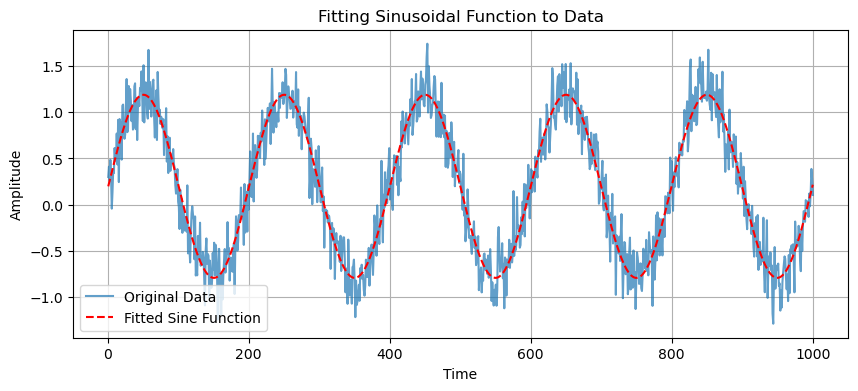

In [55]:
# Define the sine function to fit
def sine_function(x, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * x + phi) + C

# Fit the sine function to the data
popt, pcov = curve_fit(sine_function, x_data, y_data, p0=[1, 0.005, 0, 0])

# Extract the fitted parameters
A_fit, f_fit, phi_fit, C_fit = popt

# Generate fitted y-values
y_fit = sine_function(x_data, A_fit, f_fit, phi_fit, C_fit)

# Plot the original and fitted data
plt.figure(figsize=(10, 4))
plt.plot(x_data, y_data, label='Original Data', alpha=0.7)
plt.plot(x_data, y_fit, label='Fitted Sine Function', linestyle='--', color='red')
plt.title("Fitting Sinusoidal Function to Data")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
# Calculate the R-squared value
r_squared = r2_score(y_data, y_fit)
r_squared

0.920857065297626

In [73]:
r2=[]
df=pd.DataFrame(cumulative_adjusted_series,index=t,columns=['Close'])

def sine_function(x, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * x + phi) + C

for d in np.linspace(0,1,11):
    ffd=my_afml_fncs.fracDiff_FFD(df,d=d,thres=0.001)
    y_data=ffd['Close']
    x_data=ffd.index

    # Fit the sine function to the data
    popt, pcov = curve_fit(sine_function, x_data, y_data, p0=[1, 0.005, 0, 0])

    # Extract the fitted parameters
    A_fit, f_fit, phi_fit, C_fit = popt

    # Generate fitted y-values
    y_fit = sine_function(x_data, A_fit, f_fit, phi_fit, C_fit)

    r_squared = r2_score(y_data, y_fit)
    r2.append(r_squared)

print(r2)


[0.010007518248410507, 0.8216964684045979, 0.24579126851963806, 0.27966578352453864, 0.08727396864654113, 0.08288395825780392, 0.31385466984524946, 0.34918768315752713, 0.3932849219365878, 0.5496421721060212, 0.920857065297626]


5.5 Take the dollar bar series on E-mini S&P 500 futures.

5.5.a Form a new series as a cumulative sum of log prices